In [84]:

%load_ext autoreload
%autoreload 2
from rioplatense_hs.openai import get_completion
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)

few_shot_files = sorted(glob("../data/test*pred.csv"))
one_shot_files = sorted(glob("../data/test*pred*1shot.csv"))
beto_files = sorted(glob("../data/test*beto.csv"))

assert len(few_shot_files) == len(one_shot_files) == len(beto_files)

dfs = {
    "one-shot": pd.concat([pd.read_csv(f, index_col=0) for f in one_shot_files]),
    "few-shot": pd.concat([pd.read_csv(f, index_col=0) for f in few_shot_files]),
    "beto": pd.concat([pd.read_csv(f, index_col=0) for f in beto_files]),
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
assert all(dfs["few-shot"].index == dfs["one-shot"].index)
assert all(dfs["few-shot"].index == dfs["beto"].index)

## Error analysis

In [86]:
from rioplatense_hs.preprocessing import text_to_label, labels
from sklearn.metrics import classification_report

pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

In [5]:
labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]
pred_labels = [f"PRED_{label}" for label in labels]

In [6]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []

for name, df in dfs.items():
    print(name)
    for label in tqdm(labels):

        for metric in {"precision", "recall", "f1"}:
            if metric == "precision":
                score = precision_score
            elif metric == "recall":
                score = recall_score
            elif metric == "f1":
                score = f1_score


            gold_labels = df[label].values
            preds = df[f"PRED_{label}"].values

            bst = Bootstrap(metric=score)

            bst_scores = bst.run(preds, gold_labels)

            for score in bst_scores:
                metrics.append(
                    {
                        "model": name,
                        "label": label,
                        "metric": metric,
                        "score": score,
                    }
                )


one-shot


  0%|          | 0/4 [00:00<?, ?it/s]

few-shot


  0%|          | 0/4 [00:00<?, ?it/s]

beto


  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
df_metrics = pd.DataFrame(metrics)

df_metrics

,model,label,metric,score
0,one-shot,WOMEN,recall,0.283871
1,one-shot,WOMEN,recall,0.301471
2,one-shot,WOMEN,recall,0.278689
3,one-shot,WOMEN,recall,0.301587
4,one-shot,WOMEN,recall,0.309859
...,...,...,...,...
35995,beto,CLASS,f1,0.573529
35996,beto,CLASS,f1,0.614035
35997,beto,CLASS,f1,0.627737
35998,beto,CLASS,f1,0.611940


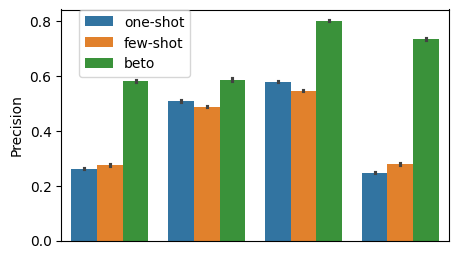

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

metric = "precision"

plt.figure(figsize=(5, 3))
sns.barplot(x='label', y='score', hue='model', data=df_metrics[df_metrics["metric"] == metric], hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.xlabel('')
plt.ylabel(metric.capitalize())

# Show the plot

# Remove xticks

plt.xticks(ticks=[])
# Make legend smaller
plt.legend(loc='upper right', bbox_to_anchor=(0.35, 1.03))

plt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

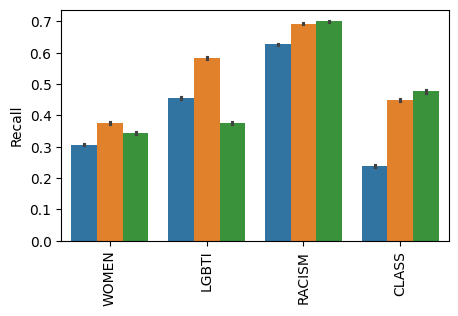

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

metric = "recall"

plt.figure(figsize=(5, 3))
sns.barplot(x='label', y='score', hue='model', data=df_metrics[df_metrics["metric"] == metric], hue_order=["one-shot", "few-shot", "beto"], legend=False)
# Remove the legend
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# Set the plot title and labels
plt.xlabel('')
plt.ylabel(metric.capitalize())

# Show the plot

plt.xticks(rotation=90)
#plt.show()
plt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

In [30]:
# Just keep the most important characteristics

hate_metrics = []


for name, df in dfs.items():
    label_hate = df[labels].sum(axis=1) > 0
    pred_hate = df[pred_labels].sum(axis=1) > 0

    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_hate.values
        preds = pred_hate.values

        bst = Bootstrap(metric=score)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,one-shot,recall,0.540881
1,one-shot,recall,0.522267
2,one-shot,recall,0.484407
3,one-shot,recall,0.516556
4,one-shot,recall,0.513238
...,...,...,...
8995,beto,f1,0.618705
8996,beto,f1,0.634921
8997,beto,f1,0.638398
8998,beto,f1,0.638498


([0, 1, 2], [Text(0, 0, 'recall'), Text(1, 0, 'precision'), Text(2, 0, 'f1')])

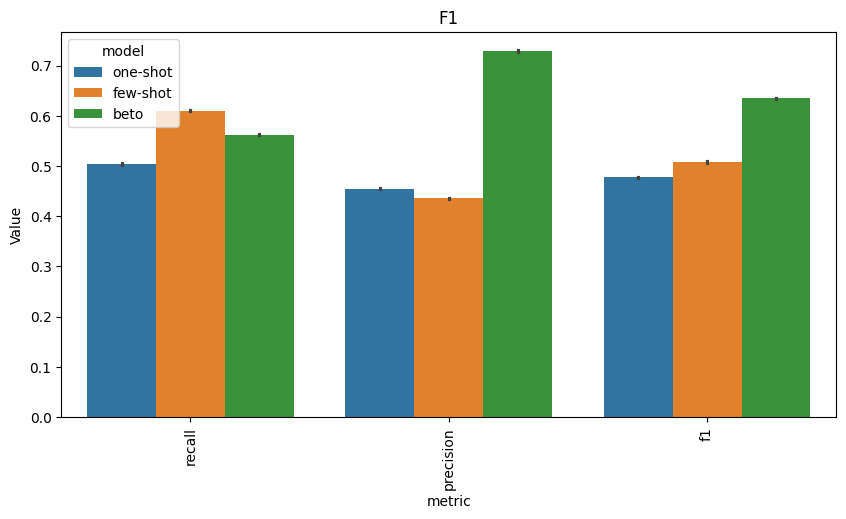

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.title(metric.capitalize())
plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

In [50]:

# Show as mean +/- std
metrics_copy = hate_metrics.copy()

metrics_copy["score"] *= 100

res = metrics_copy.groupby(["model", "metric"]).mean().round(1).astype(str) + " \pm " + metrics_copy.groupby(["model", "metric"]).std().round(1).astype(str)

res

score
model    metric                 
beto     f1         63.5 \pm 1.9
         precision  72.9 \pm 2.3
         recall     56.2 \pm 2.1
few-shot f1         50.8 \pm 1.8
         precision  43.5 \pm 1.9
         recall     61.0 \pm 2.2
one-shot f1         47.8 \pm 1.9
         precision  45.5 \pm 2.1
         recall     50.4 \pm 2.2

In [51]:
# Convert metrics to columns

print(res.reset_index().pivot(index="model", columns="metric", values="score").to_latex())

\begin{tabular}{llll}
\toprule
metric & f1 & precision & recall \\
model &  &  &  \\
\midrule
beto & 63.5 \pm 1.9 & 72.9 \pm 2.3 & 56.2 \pm 2.1 \\
few-shot & 50.8 \pm 1.8 & 43.5 \pm 1.9 & 61.0 \pm 2.2 \\
one-shot & 47.8 \pm 1.9 & 45.5 \pm 2.1 & 50.4 \pm 2.2 \\
\bottomrule
\end{tabular}



## LGBTI 

BETO vs few-shot ChatGPT

In [87]:
# Merge dfs['few-shot'] and dfs['beto']

columns_to_drop = [
    "title", "text", "context_tweet", "HATEFUL", "CALLS", "WOMEN", "LGBTI", "RACISM", "CLASS", "POLITICS", "DISABLED", "CRIMINAL", "APPEARANCE",
    "PRED_CALLS", "PRED_POLITICS", "PRED_DISABLED", "PRED_CRIMINAL", "PRED_APPEARANCE",
]



df_join = dfs["few-shot"].join(dfs["beto"].drop(columns_to_drop, axis=1), rsuffix="_beto")

cols = [c for c in df_join.columns if c.isupper() and "SCORE" not in c]

df_join[cols] = df_join[cols].astype(bool)

Ejemplos que falla BETO y acierta ChatGPT y eran LGBTI

In [88]:
df_join.columns

Index(['title', 'text', 'context_tweet', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI',
       'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL',
       'prompt', 'pred_cot', 'PRED_WOMEN', 'PRED_LGBTI', 'PRED_RACISM',
       'PRED_CLASS', 'PRED_POLITICS', 'PRED_DISABLED', 'PRED_APPEARANCE',
       'PRED_CRIMINAL', 'PRED_HATEFUL', 'PRED_WOMEN_beto', 'PRED_LGBTI_beto',
       'PRED_RACISM_beto', 'PRED_CLASS_beto', 'SCORE_WOMEN', 'SCORE_LGBTI',
       'SCORE_RACISM', 'SCORE_CLASS', 'SCORE_POLITICS', 'SCORE_DISABLED',
       'SCORE_APPEARANCE', 'SCORE_CRIMINAL'],
      dtype='object')

In [89]:
df_join.loc[df_join["LGBTI"] & df_join["PRED_LGBTI"] & ~df_join["PRED_LGBTI_beto"]][["context_tweet", "text", "pred_cot", "SCORE_LGBTI"]]

,context_tweet,text,pred_cot,SCORE_LGBTI
id,,,,
405355,Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario https://t.co/M0K3NXgfA8,@usuario En la autopsia no debe figurar la próstata por ley! 😄,"El texto hace una referencia burlona a la identidad de género de la mujer trans y a la eliminación de su próstata. La respuesta final es ""lgbti"".",0.061692
405366,Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario https://t.co/M0K3NXgfA8,@usuario Salió de caño... cuac!,"El texto hace referencia a que la mujer trans ""salió de caño"", lo cual es un término despectivo relacionado a la identidad de género. La respuesta final es ""lgbti"".",0.001594
327760,Los infectados en villas porteñas crecieron un 80% en cuatro días https://t.co/8Cc7pgnSzG https://t.co/iOpldGjWAz,"@usuario Ojalá que el virus penetre más en las villas y maten a todos esos delincuentes que viven ahi, hay paraguayos narcos, bolivianos que traen la droga de bolivia, y gente de mala vida. También hay travas que van a trabajar de noche a palermo.","El texto alude a las personas que viven en villas como delincuentes, menciona nacionalidades específicas (paraguayos, bolivianos) de manera despectiva y hace referencia a travestis como parte de un estereotipo negativo. La respuesta final es ""clase, criminal, lgbti"".",0.017190
405362,Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario https://t.co/M0K3NXgfA8,@usuario Cómo no saco su escopeta y aplicó la defensa propia?!,"El texto alude a que la mujer trans debería haber utilizado una escopeta para defenderse y evitar su asesinato. La respuesta final es ""lgbti, criminal"".",0.010081
390770,″¿Por qué un beso entre dos hombres los vuelve tan violentos?”: la vida después de haber sido víctima de ataques homofóbicos | Por Milton Del Moral https://t.co/MgHNMf8Sch,@usuario Porque es desagradable,"El texto expresa su desagrado hacia el beso entre dos hombres, lo cual puede considerarse como homofobia. La respuesta final es ""lgbti"".",0.018116
397546,Así luce el actor Elliot Page tras declararse trans https://t.co/yeTGhw6ooT,@usuario Che... Qué diferencia hay entre Trans y un Trabuco??,"El texto se refiere despectivamente a las personas trans y hace una comparación ofensiva. La respuesta final es ""lgbti"".",0.126789
395337,"El exabrupto de Jair Bolsonaro sobre Brasil y el Covid-19: ""Tienen que dejar de ser un país de maricas"" https://t.co/WtxRjY7tJp",@usuario Ser zurdo es de marica! Revienten cagones!,"El texto alude a la homosexualidad como algo negativo y utiliza el término ""marica"" como un insulto. La respuesta final es ""lgbti"".",0.163100
390767,″¿Por qué un beso entre dos hombres los vuelve tan violentos?”: la vida después de haber sido víctima de ataques homofóbicos | Por Milton Del Moral https://t.co/MgHNMf8Sch,@usuario Será xq va contra la naturaleza de la raza...,"El texto alude a que un beso entre dos hombres va en contra de la ""naturaleza de la raza"", insinuando que la homosexualidad no es natural. La respuesta final es ""lgbti, racismo"".",0.005803
398935,Mara Gómez: la historia de la primera futbolista trans en el torneo argentino https://t.co/rBx3pMPUbB https://t.co/l5I1j0xFku,@usuario Para mi tendrían q ser todas trans así juegan bien a la pelota. Son inmirables los partidos. Ojalá haya 100% de trans en el fútbol femenino.\nVamos Mara. \n\nFirma: los espectadores,"El texto alude a que las futbolistas trans juegan bien a la pelota y sugiere que deberían ser todas trans en el fútbol femenino. Además, se refiere a los espectadores como firmantes de esta declaración. La respuesta final es ""lgbti"".",0.332832
